In [ ]:
# --- Conexão com MongoDB ---
# === CONFIGURAÇÕES ===
!pip install supabase
!pip install pymongo
!pip install pandas
!pip install "pymongo[srv]"
!pip install dnspython
import random
import string
import certifi
import os
import pandas as pd
import time
from supabase import create_client, Client
from pymongo import MongoClient
from matplotlib import pyplot as plt

#MongoDB
uri = "urlmongo"
client = MongoClient(uri, tls=True, tlsCAFile=certifi.where(), serverSelectionTimeoutMS=30000)
db = client["nomebanco"]

print("✅ Conexão com MongoDB Atlas estabelecida com sucesso!")

try:
    client.admin.command("ping")
    print("✅ Conexão MongoDB Atlas OK (ping)")
except Exception as e:
    print("❌ Falha no ping do MongoDB:", e)

✅ Conexão com MongoDB Atlas estabelecida com sucesso!
✅ Conexão MongoDB Atlas OK (ping)


In [ ]:
# --- Execução de etapa do benchmark ---
#Limpa tudo antes do testes
def limpar_mongodb():
    """Apaga TODOS os documentos de TODAS as coleções do banco atual `db`.
    Ajuste se quiser preservar algo específico.
    """
    for nome in db.list_collection_names():
        db[nome].delete_many({})
    print("✅ MongoDB limpo (todas as coleções esvaziadas)")

In [ ]:
# --- Benchmark de performance ---
# Supabase
SUPABASE_URL = os.getenv("SUPABASE_URL", "url banco supabase")
SUPABASE_ANON_KEY = os.getenv("SUPABASE_ANON_KEY", "chave supabase")
supabase: Client = create_client(SUPABASE_URL, SUPABASE_ANON_KEY)

#mongo 2(dados de acesso)
MONGODB_URI = "url mongo"
colecao = db["usuarios"]

#tabelas e coleções
SUPABASE_TABLE = "produtos"
MONGODB_DB = "benchmark_db"
MONGODB_COLLECTION = "produtos"
mongo_db = client[MONGODB_DB]
mongo_col = mongo_db[MONGODB_COLLECTION]

# Parâmetros do benchmark
N_REGISTROS = 2000
REPETICOES = 3
BATCH_SIZE_SUPABASE = 500
BATCH_SIZE_MONGO = 1000

print("✅ Conectado ao Supabase:", SUPABASE_URL)
print("✅ Conectado ao MongoDB:", MONGODB_DB, "/", MONGODB_COLLECTION)

✅ Conectado ao Supabase: https://vsttaoaahwzakcpexpyy.supabase.co
✅ Conectado ao MongoDB: benchmark_db / produtos


In [ ]:
# --- Benchmark de performance ---
# === Funções de limpeza 2 para garantir funcionamento===
def limpar_supabase():
    try:
        supabase.table(SUPABASE_TABLE).delete().neq("id", 0).execute()
    except Exception as e:
        raise RuntimeError(
            f"A tabela '{SUPABASE_TABLE}' não existe.\n"
            "Crie no painel SQL do Supabase antes de rodar o benchmark:\n\n"
            f"CREATE TABLE IF NOT EXISTS public.{SUPABASE_TABLE} (\n"
            f"  id BIGSERIAL PRIMARY KEY,\n"
            f"  nome TEXT,\n"
            f"  preco NUMERIC,\n"
            f"  quantidade INT,\n"
            f"  categoria TEXT\n"
            f");"
        ) from e

def limpar_mongodb():
    if MONGODB_COLLECTION in mongo_db.list_collection_names():
        mongo_col.delete_many({})
    else:
        mongo_db.create_collection(MONGODB_COLLECTION)
def criar_tabela_supabase():
    try:
        supabase.rpc("sql", {
            "query": """
            CREATE TABLE IF NOT EXISTS public.produtos (
              id BIGSERIAL PRIMARY KEY,
              nome TEXT,
              preco NUMERIC,
              quantidade INT,
              categoria TEXT
            );
            """
        }).execute()
        print("Tabela 'produtos' verificada/criada no Supabase.")
    except Exception as e:
        print("Erro ao criar tabela no Supabase:", e)

In [ ]:


def gerar_dados(n_registros):
    """Gera uma lista de dicionários representando registros de produtos."""
    categorias = ["Eletrônicos", "Livros", "Roupas", "Alimentos", "Decoração"]
    dados = []
    for i in range(n_registros):
        dados.append({
            "nome": f"Produto {i+1}",
            "preco": round(random.uniform(10, 1000), 2),
            "quantidade": random.randint(1, 100),
            "categoria": random.choice(categorias)
        })
    return dados

def tempo_ms(func, *args, **kwargs):
    """Mede o tempo de execução de uma função em milissegundos."""
    inicio = time.time()
    resultado = func(*args, **kwargs)
    fim = time.time()
    return (fim - inicio) * 1000

def resumo_tempos(alvo, tempos):
    """Calcula estatísticas básicas para uma lista de tempos."""
    if not tempos:
        return {"alvo": alvo, "n": 0, "media_ms": None, "desvio_padrao_ms": None, "min_ms": None, "max_ms": None}
    tempos_np = pd.Series(tempos)
    return {
        "alvo": alvo,
        "n": len(tempos),
        "media_ms": tempos_np.mean(),
        "desvio_padrao_ms": tempos_np.std(),
        "min_ms": tempos_np.min(),
        "max_ms": tempos_np.max()
    }

def inserir_supabase(dados):
    """Insere dados no Supabase em lotes."""
    for i in range(0, len(dados), BATCH_SIZE_SUPABASE):
        batch = dados[i:i + BATCH_SIZE_SUPABASE]
        response = supabase.table(SUPABASE_TABLE).insert(batch).execute()
        if response.data is None:
             print(f"Erro ao inserir lote no Supabase: {response.error}")
             pass


def ler_supabase():
    """Lê todos os dados do Supabase."""
    response = supabase.table(SUPABASE_TABLE).select("*").execute()
    if response.data is None:
        print(f"Erro ao ler do Supabase: {response.error}")
        return []
    return response.data

def inserir_mongodb(dados):
    """Insere dados no MongoDB em lotes."""
    if dados:
        try:
            mongo_col.insert_many(dados, ordered=False)
        except Exception as e:
             print(f"Erro ao inserir lote no MongoDB: {e}")
             pass

def ler_mongodb():
    """Lê todos os dados do MongoDB."""
    return list(mongo_col.find())



## Benchmark Consolidado
Nesta etapa, realizamos **todas as operações** de benchmark em um único fluxo:

- Inserção em lote
- Leitura simples
- Consulta de agregação (contagem por campo)

Foram utilizados **200 registros** para garantir volume suficiente de dados.


=== Repetição 1/3 ===
Inserção Supabase: 477.62 ms | MongoDB: 1269.35 ms
Leitura Supabase:  448.56 ms | MongoDB: 260.14 ms
Agregação Supabase: 449.29 ms | MongoDB: 267.01 ms

=== Repetição 2/3 ===
Inserção Supabase: 192.72 ms | MongoDB: 1264.09 ms
Leitura Supabase:  179.63 ms | MongoDB: 257.80 ms
Agregação Supabase: 194.18 ms | MongoDB: 260.19 ms

=== Repetição 3/3 ===
Inserção Supabase: 208.79 ms | MongoDB: 1659.31 ms
Leitura Supabase:  198.55 ms | MongoDB: 259.00 ms
Agregação Supabase: 185.99 ms | MongoDB: 260.96 ms


,alvo,n,media_ms,desvio_padrao_ms,min_ms,max_ms
0,Supabase - Inserção (200),3,293.043693,160.052056,192.721367,477.622986
1,MongoDB - Inserção (200),3,1397.584279,226.675656,1264.090776,1659.309149
2,Supabase - Leitura (200),3,275.581360,150.105152,179.627657,448.563099
3,MongoDB - Leitura (200),3,258.978764,1.170279,257.798910,260.139227
4,Supabase - Agregação (200),3,276.485682,149.706064,185.991049,449.286699
5,MongoDB - Agregação (200),3,262.720664,3.736879,260.187149,267.012358


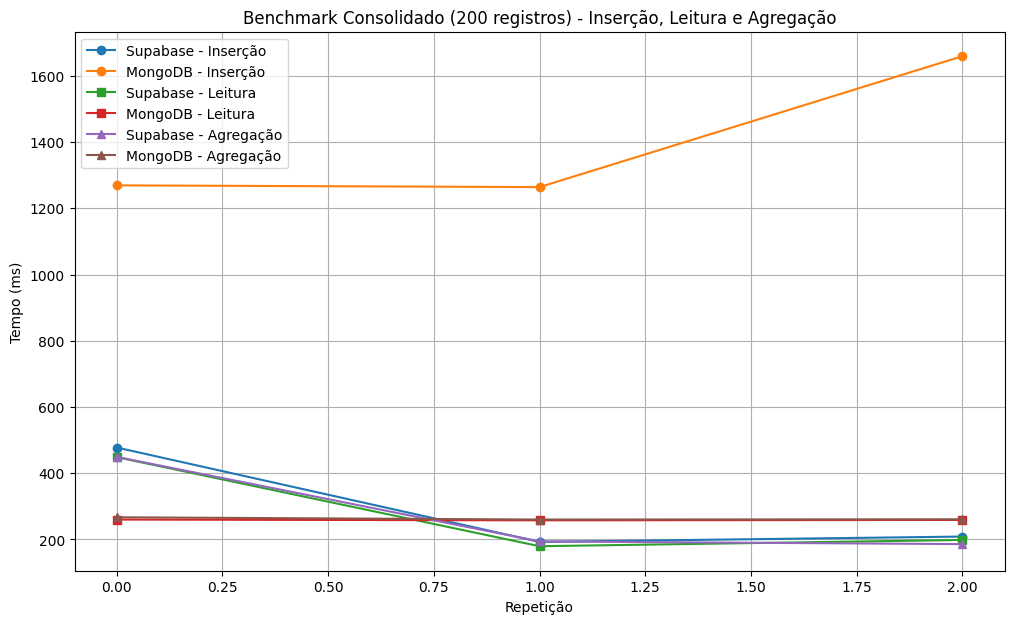

In [ ]:
# --- Benchmark Consolidado: Inserção, Leitura e Agregação ---
N_REGISTROS = 200  # número de registros para este teste

tempos_ins_supabase, tempos_le_supabase, tempos_agg_supabase = [], [], []
tempos_ins_mongo, tempos_le_mongo, tempos_agg_mongo = [], [], []

for rep in range(REPETICOES):
    print(f"\n=== Repetição {rep+1}/{REPETICOES} ===")
    dados_base = gerar_dados(N_REGISTROS)

    limpar_supabase()
    limpar_mongodb()

    # Inserção em lote
    t_sup_ins = tempo_ms(inserir_supabase, dados_base)
    t_mon_ins = tempo_ms(inserir_mongodb, dados_base)
    print(f"Inserção Supabase: {t_sup_ins:.2f} ms | MongoDB: {t_mon_ins:.2f} ms")

    # Leitura simples
    t_sup_le = tempo_ms(ler_supabase)
    t_mon_le = tempo_ms(ler_mongodb)
    print(f"Leitura Supabase:  {t_sup_le:.2f} ms | MongoDB: {t_mon_le:.2f} ms")

    # Agregação: contar registros por campo 'categoria'
    t_sup_agg = tempo_ms(lambda: pd.DataFrame(ler_supabase()).groupby("categoria").size())
    t_mon_agg = tempo_ms(lambda: pd.DataFrame(ler_mongodb()).groupby("categoria").size())
    print(f"Agregação Supabase: {t_sup_agg:.2f} ms | MongoDB: {t_mon_agg:.2f} ms")

    tempos_ins_supabase.append(t_sup_ins)
    tempos_ins_mongo.append(t_mon_ins)
    tempos_le_supabase.append(t_sup_le)
    tempos_le_mongo.append(t_mon_le)
    tempos_agg_supabase.append(t_sup_agg)
    tempos_agg_mongo.append(t_mon_agg)

# Resumo estatístico consolidado
res_final = [
    resumo_tempos("Supabase - Inserção (200)", tempos_ins_supabase),
    resumo_tempos("MongoDB  - Inserção (200)", tempos_ins_mongo),
    resumo_tempos("Supabase - Leitura (200)", tempos_le_supabase),
    resumo_tempos("MongoDB  - Leitura (200)", tempos_le_mongo),
    resumo_tempos("Supabase - Agregação (200)", tempos_agg_supabase),
    resumo_tempos("MongoDB  - Agregação (200)", tempos_agg_mongo),
]

df_final = pd.DataFrame(res_final)[["alvo","n","media_ms","desvio_padrao_ms","min_ms","max_ms"]]
display(df_final)

# --- Visualização única consolidada ---
plt.figure(figsize=(12,7))
plt.plot(tempos_ins_supabase, label="Supabase - Inserção", marker="o")
plt.plot(tempos_ins_mongo, label="MongoDB - Inserção", marker="o")
plt.plot(tempos_le_supabase, label="Supabase - Leitura", marker="s")
plt.plot(tempos_le_mongo, label="MongoDB - Leitura", marker="s")
plt.plot(tempos_agg_supabase, label="Supabase - Agregação", marker="^")
plt.plot(tempos_agg_mongo, label="MongoDB - Agregação", marker="^")

plt.title("Benchmark Consolidado (200 registros) - Inserção, Leitura e Agregação")
plt.xlabel("Repetição")
plt.ylabel("Tempo (ms)")
plt.legend()
plt.grid(True)
plt.show()


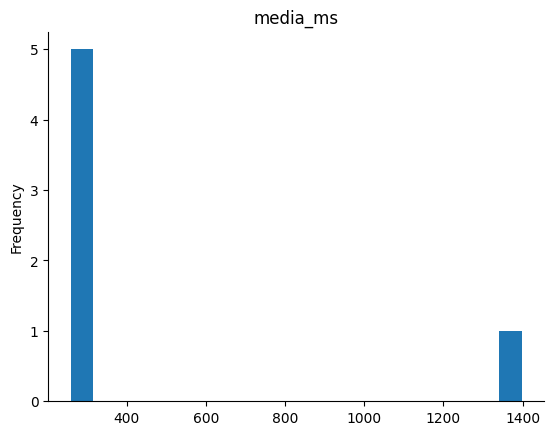

In [ ]:
df_final['media_ms'].plot(kind='hist', bins=20, title='media_ms')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()